<a href="https://colab.research.google.com/github/HopeMoloko/Competitions/blob/master/Crops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some images may contain both stem and leaf rust, there is always one type of rust that is more dominant than the other, i.e. you will not find images where both appear equally. The goal is to classify the image according to the type of wheat rust that appears most prominently in the image

# Mount the google drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'datasets/'

Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#!sudo apt install imagemagick


# Conversion
 - Some images are .jfif and we want jpg. 

In [0]:
# !cd test; mogrify -format jpg *.jfif
# !cd train/healthy_wheat; mogrify -format jpg *.jfif  
# !cd train/leaf_rust; mogrify -format jpg *.jfif  
# !cd train/stem_rust; mogrify -format jpg *.jfif 

In [0]:
from fastai.vision import *
#from fastai.metrics import CrossEntropyFlat
from fastai.basic_train import *

In [0]:
path = Path(base_dir + 'Crops')
#dest = path
#dest.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content/gdrive/My Drive/datasets/Crops')

# Load Image data of size 256 


*   Size 128 already done
*   Load for size 256



In [0]:
np.random.seed(42)   # If we run the cell again the validation set must remain the same.
tfms = get_transforms(max_zoom=1.5)
src = (ImageList.from_folder(path/'train') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)             #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder())              #Optionally add a test set (here default name is test)
 


In [0]:
data = (src.transform(tfms, size=128)             # Forr now it's 128
        .databunch().normalize(imagenet_stats))

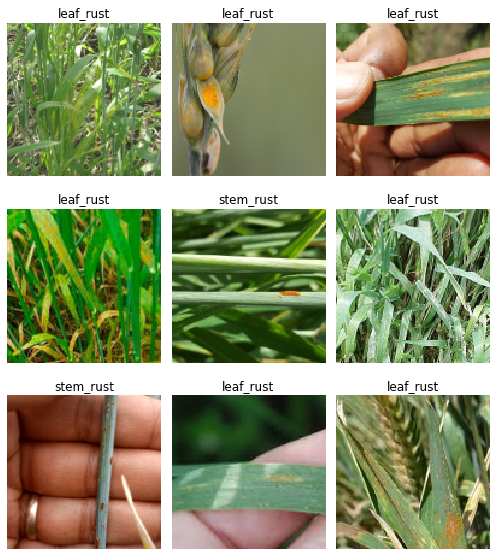

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes   #Check the classes we have

['healthy_wheat', 'leaf_rust', 'stem_rust']

In [0]:
arch = models.resnet50    # Our architecture

In [0]:
learn = cnn_learner(data, arch, metrics=[accuracy])   # Create the learner

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


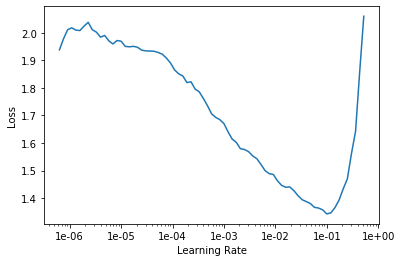

In [0]:
learn.recorder.plot()

In [0]:
lr=1e-2


In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.667118,1.707214,0.651429,01:53
1,1.408298,1.230254,0.731429,01:53
2,1.148877,0.612717,0.794286,01:53
3,0.967664,0.622298,0.794286,01:54
4,0.822417,0.583307,0.794286,01:54


In [0]:
learn.save('stage-1-128-rsn50_v3')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


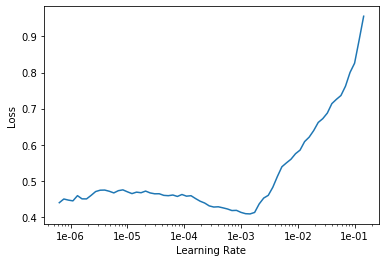

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
1e-04

0.0001

In [0]:
learn.fit_one_cycle(5, slice(1e-05, 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.426458,0.577870,0.805714,01:51
1,0.409082,0.589358,0.794286,01:53
2,0.384529,0.529046,0.805714,01:53
3,0.364934,0.499648,0.822857,01:54
4,0.352216,0.505718,0.828571,01:52


In [0]:
learn.save('stage-2-128-rsn50_v3')

# Let's go to SIZE 256 now with out rsnet34

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
#learn.load('stage-2-128-rsn50_v2')

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


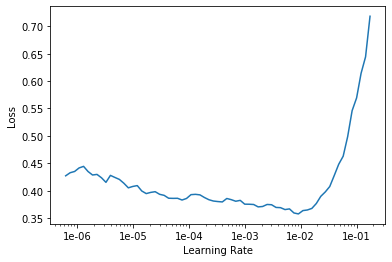

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(6, slice(1e-04 , 1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.412837,0.442754,0.851429,02:06
1,0.368650,0.683535,0.840000,02:07
2,0.375276,0.698526,0.828571,02:07
3,0.336222,0.568480,0.885714,02:07
4,0.285900,0.629461,0.851429,02:07
5,0.245364,0.549293,0.874286,02:06


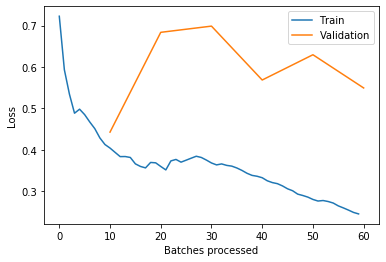

In [0]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


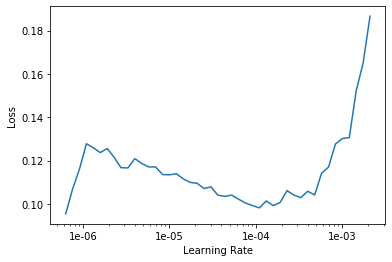

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-05 , 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.113023,0.416543,0.891429,02:10
1,0.103515,0.485677,0.868571,02:10
2,0.107249,0.505392,0.862857,02:13
3,0.095495,0.501272,0.868571,02:10
4,0.086571,0.486110,0.868571,02:10


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

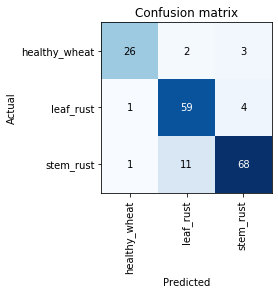

In [0]:
interp.plot_confusion_matrix()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


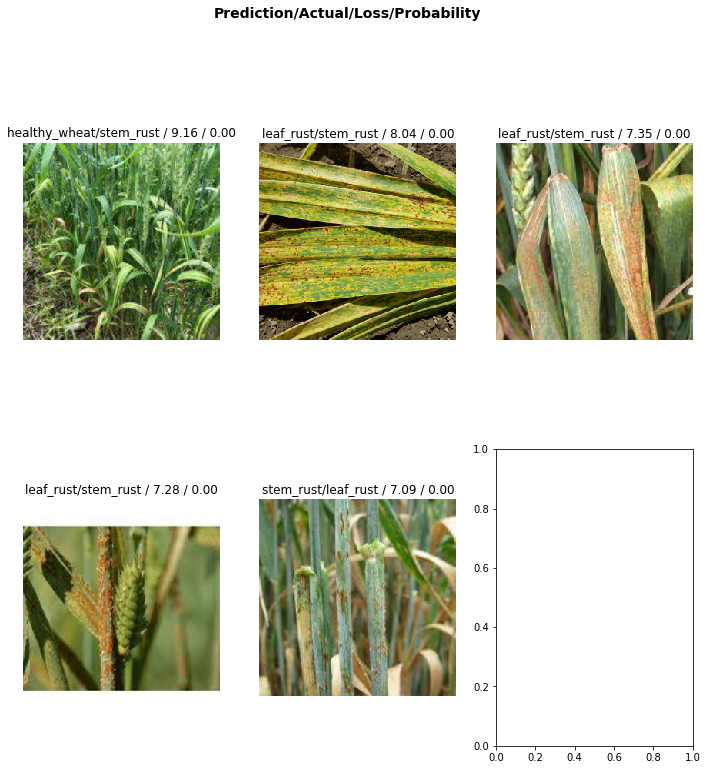

In [0]:
interp.plot_top_losses(5)

In [0]:
learn.save('stage-2-256-rsn50_v3')

In [0]:
learn.export('crops-rsn50_v3.pkl')

# Make predictions and save them to submission.csv

In [0]:
import pandas as pd
import numpy as np

In [0]:
test = ImageList.from_folder(path/'test')
learn = load_learner(path/'train','crops-rsn50_v3.pkl', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)




In [0]:
labelled_preds = [list(pred) for pred in preds]
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
healthy_wheat_preds = [ to_np(P[0]) for P in labelled_preds]
leaf_rust_preds = [ to_np(P1[1]) for P1 in labelled_preds]
stem_rust_preds = [ to_np(P2[2]) for P2 in labelled_preds]

In [0]:
df = pd.DataFrame({'ID':fnames, 'leaf_rust':leaf_rust_preds ,'stem_rust':stem_rust_preds , 'healthy_wheat':healthy_wheat_preds},
                 columns=['ID', 'leaf_rust' , 'stem_rust' ,'healthy_wheat'])


In [0]:
df

,ID,leaf_rust,stem_rust,healthy_wheat
0,M9RQNE,0.054460734,0.9426457,0.002893501
1,LT0KA0,0.055673115,0.8696474,0.07467954
2,QSLW1A,5.649979e-06,0.9993801,0.0006142524
3,1R1HEY,0.06331563,0.93136275,0.0053216196
4,UC43IC,0.96249557,0.022291189,0.015213293
...,...,...,...,...
605,YQL491,0.99991274,4.0804367e-05,4.6436217e-05
606,YYYK9H,0.9847207,0.00013613919,0.015143096
607,ZCZR1I,0.289147,0.0083742365,0.70247877
608,ZDPAP7,0.8627959,0.0017646707,0.13543946


In [0]:
df.to_csv(path/'submission_4.csv', index=False)
print(df.head())

       ID     leaf_rust    stem_rust healthy_wheat
0  M9RQNE   0.054460734    0.9426457   0.002893501
1  LT0KA0   0.055673115    0.8696474    0.07467954
2  QSLW1A  5.649979e-06    0.9993801  0.0006142524
3  1R1HEY    0.06331563   0.93136275  0.0053216196
4  UC43IC    0.96249557  0.022291189   0.015213293
